### Remaining: 
- Fix birth year extract (account for non '-' split)
- Tie last names to general country they're from?

# Introduction
My fiancee and I are both interested by our geneology, and subsequently have an [Ancestry account](www.ancestry.com).  When it came time to renew our account, we had to take a look at the budget due to me being in grad school (and thus foregoing the income I previously had).

We both have family that reaches *really* far back (...in American terms), and have put in a lot of time to put everything together.  I found out you can extract a [GEDCOM](https://en.wikipedia.org/wiki/GEDCOM) (GEneological Data COMmunication) file, and since I was trying to improve my Python data munging skills, I thought - why not analyze my ancestry?

There are a few Python packages out there that will load a GEDCOM file directly into Python, but I ended up using the GNU program [GRAMPS](https://gramps-project.org/) to convert it into a series of CSVs.  GRAMPS technically does about 80% of what I wanted to do - and is ironically built with Python - but just using it wouldn't be nearly as fun

# Questions to Explore
- Question 1
- Mobility over time


# Caveats
In addition to the data being **really** messy, there are a few restrictions that will impact some of the analysis:
* The basic Ancestry account will only pull records for those residing in the United States
* While my mom's side of the family in the US goes back to colonial times, my dad's side of the family are relatively recent immigrants from Italy, so this will show when looking at specific things like countries of birth
- Time won on some of some of the time vs. quality tradeoffs due to the level of the how messy some of the data is.  My favorite example being "somewhere in the delta" being listed as a birth place.  This may be worth fixing in a professional setting for looking at the state and country of birth, but wasn't worth the time to fix it for my purposes

With that all said, let's get started!

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vincent  # used for plotting map data
%matplotlib inline


plt.style.use('seaborn-deep')
pd.set_option('display.max_columns', None)  # Displays all columns - needed since our data frames will be wide

# Part I
## The Data
We have four CSVs at our disposal:
- Individual Detail: The bulk of our data - one row for every individual with various information shown below
- Marriage Detail: The husband/wife, date, place of marriage, and a "family" key
- Family Detail: The "family" key and children
- Place Detail: The "place" key and address.  I didn't end up using it, but I would have if I wanted to look at locations of marriage or burial

Since some of the columns in the tables had either little or no data, I included lines to drop any columns without data, and manually viewed each table with the Pandas .info() command to see which columns contained too few records to be of use.

You'll also see as we go on, but this data is *messy*.  It has a lot of missing records, and some of the data is outright in the wrong place.  The formatting is very inconsistent.  For example, I have seen the following formats for dates: '29 Dec, 1865', '12/29/1865', '1865-12-29', '1860s', and 'about Dec 1865'.

In [237]:
# Individual Detail
df = pd.read_csv('C:\\Users\\JeffM\\Documents\\Ancestry Files\\Macaluso_Tree.csv', nrows = 489)
df.dropna(axis = 'columns', how = 'all', inplace = True)  # Drops any column that doesn't contain any data
df.info()

# Marriage Detail
Marriage = pd.read_csv('C:\\Users\\JeffM\\Documents\\Ancestry Files\\Macaluso_Tree.csv', skiprows = 490, nrows = 87)
Marriage.dropna(axis = 'columns', how = 'all', inplace = True)

# Family Detail
Family = pd.read_csv('C:\\Users\\JeffM\\Documents\\Ancestry Files\\Macaluso_Tree.csv', skiprows = 579, nrows = 407)
Family.dropna(axis = 'columns', how = 'all', inplace = True)

# Place Detail - Removed due to never using it
"""
Place = pd.read_csv('C:\\Users\\JeffM\\Documents\\Ancestry Files\\Macaluso_Tree.csv', skiprows = 988)
Place.dropna(axis = 'columns', how = 'all', inplace = True)
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 488
Data columns (total 13 columns):
Person           489 non-null object
Surname          483 non-null object
Given            486 non-null object
Suffix           20 non-null object
Gender           489 non-null object
Birth date       460 non-null object
Birth place      400 non-null object
Birth source     132 non-null object
Death date       308 non-null object
Death place      250 non-null object
Death source     36 non-null object
Burial place     21 non-null object
Burial source    20 non-null object
dtypes: object(13)
memory usage: 53.5+ KB


"\nPlace = pd.read_csv('C:\\Users\\JeffM\\Documents\\Ancestry Files\\Macaluso_Tree.csv', skiprows = 988)\nPlace.dropna(axis = 'columns', how = 'all', inplace = True)\n"

In [238]:
# Too few sources to bother with
df.drop(['Birth source', 'Death source', 'Burial source'], axis = 1, inplace = True)

# Create a new column for full name.  Correcting often misspelled last name.
df.replace(to_replace = 'MacAluso', value = 'Macaluso', inplace = True)  # No, it's not Scottish or Irish
df["Name"] = df["Given"].map(str) + " " + df["Surname"]

# Renaming the columns to make them more intuitive
Family.columns = ['Family', 'Person']

In order to combine the three tables and tie the parents to the children, I had to join the Marriage data frame to the Individual data frame before combining everything together.

Here's a quick look at the information I'll be adding to the main data frame for the parents.  You can also see the 'about 1842' under the Father Birth date column, no country listed for the first record under Father Birth place, and a lot of missing values.

In [239]:
Father_Info = df.drop(['Surname', 'Given', 'Suffix', 'Gender'], axis = 1)

Father_Info.columns = ['Husband', 'Father Birth date', 'Father Birth place', 'Father Death date', 'Father Death place', 'Father Burial place', 'Father Name']

Father = pd.concat([Marriage['Husband']], axis=1)  # Inner join to limit the list to only husbands

Father = Father.merge(Father_Info, on = 'Husband')

Father.tail()

,Husband,Father Birth date,Father Birth place,Father Death date,Father Death place,Father Burial place,Father Name
80,[P481],about 1842,New York,NaN,NaN,NaN,Willett Green
81,[P141],NaN,NaN,NaN,NaN,NaN,John McKee
82,[P130],NaN,NaN,NaN,NaN,NaN,Daniel McDonald Sr
83,[P192],1650,"Lambeth, London, England",NaN,NaN,NaN,John Rasbury
84,[P430],1645,"Anne Arundel County, Maryland",NaN,"Anne Arundel County, Maryland",NaN,nan Bagley


Doing the same thing for the mother.  Even though these are more recent dates, you can see that the data isn't cleaner.

In [240]:
Mother_Info = df.drop(['Surname', 'Given', 'Suffix', 'Gender'], axis = 1)

Mother_Info.columns = ['Wife', 'Mother Birth date', 'Mother Birth place', 'Mother Death date', 'Mother Death place', 'Mother Burial place', 'Mother Name']

Mother = pd.concat([Marriage['Wife']], axis=1)

Mother = Mother.merge(Mother_Info, on = 'Wife')

Mother.tail()

,Wife,Mother Birth date,Mother Birth place,Mother Death date,Mother Death place,Mother Burial place,Mother Name
77,[P478],about 1884,New York,NaN,NaN,NaN,Mabel Greene
78,[P480],about 1843,New York,NaN,NaN,NaN,Sarah Green
79,[P140],NaN,NaN,NaN,NaN,NaN,Margaret McKee
80,[P27],about 1856,NaN,about 1916,"Tacoma, Pierce County, Washington, USA",NaN,Gecomina Damico
81,[P129],NaN,NaN,NaN,NaN,NaN,Emma Flora McDonald


In [241]:
# Merge the Family dataframe to assign the family ID for other joins
df = pd.merge(df, Family, on = 'Person', how = 'left')

In [242]:
# Merge the Marriage dataframe to assign the mother and father
Marriage.columns = ['Family', 'FatherKey', 'MotherKey', 'Date', 'Place', 'Source']
df = pd.merge(df, Marriage, on = 'Family', how = 'left')

Now to finish up the merges, and get a look at summary statistics and a slice of our data frame.

Note: I keep using df.info() instead of df.describe() since I only really care about how many non-null records there are due to every column being either a string or inconsistently formatted date.

In [243]:
# Merge the parental info on the data frame
df = pd.merge(df, Father, how = 'left', left_on = 'FatherKey', right_on = 'Husband')
df = pd.merge(df, Mother, how = 'left', left_on = 'MotherKey', right_on = 'Wife')
df.drop(['Husband', 'Wife', 'MotherKey', 'FatherKey', 'Suffix', 'Date', 'Place', 'Source'], axis = 1, inplace = True)
df.drop_duplicates(inplace = True)  # To account for dupliciate rows later discovered

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 590
Data columns (total 23 columns):
Person                 490 non-null object
Surname                484 non-null object
Given                  487 non-null object
Gender                 490 non-null object
Birth date             461 non-null object
Birth place            401 non-null object
Death date             309 non-null object
Death place            251 non-null object
Burial place           21 non-null object
Name                   484 non-null object
Family                 407 non-null object
Father Birth date      396 non-null object
Father Birth place     400 non-null object
Father Death date      365 non-null object
Father Death place     366 non-null object
Father Burial place    64 non-null object
Father Name            405 non-null object
Mother Birth date      388 non-null object
Mother Birth place     382 non-null object
Mother Death date      345 non-null object
Mother Death place     326 non-null o

In [244]:
# Renaming columns to remove spaces for dot notation
df.columns = ['PersonKey', 'Surname', 'Given', 'Gender', 'BirthDate', 'BirthPlace', 'DeathDate', 'DeathPlace',
              'BurialPlace', 'Name', 'Family', 'FatherBirthDate', 'FatherBirthPlace', 'FatherDeathDate','FatherDeathPlace',
              'FatherBurialPlace', 'FatherName', 'MotherBirthDate', 'MotherBirthPlace', 'MotherDeathDate', 'MotherDeathPlace',
               'MotherBurialPlace', 'MotherName']

Here's a good look at some more recent data with a couple of great uncles, a great aunt, and my grandpa on my dad's side.  You also can see the recency of my Italian side under the Father/Mother Birth Place columns.

In [245]:
df.ix[331:334]

,PersonKey,Surname,Given,Gender,BirthDate,BirthPlace,DeathDate,DeathPlace,BurialPlace,Name,Family,FatherBirthDate,FatherBirthPlace,FatherDeathDate,FatherDeathPlace,FatherBurialPlace,FatherName,MotherBirthDate,MotherBirthPlace,MotherDeathDate,MotherDeathPlace,MotherBurialPlace,MotherName
331,[P28],Macaluso,Frank,male,1913-11-11,Washington,1999-04-21,"Anderson Island, Pierce, Washington, United St...","Tacoma, Pierce County, Washington, USA",Frank Macaluso,[F0005],1884-04-21,"Alimena, Sicilia, Italy",16 February 1976,"Tacoma, Pierce, Washington, United States of A...",NaN,Joseph Macaluso,1892,Italy,1965-03-03,Tacoma,NaN,Francesca Romano
332,[P9],Macaluso,James Joseph,male,NaN,NaN,about 1969,NaN,NaN,James Joseph Macaluso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,[P34],Macaluso,Joseph,male,about 1934,"Tacoma, Pierce County, Washington, USA",NaN,NaN,NaN,Joseph Macaluso,[F0005],1884-04-21,"Alimena, Sicilia, Italy",16 February 1976,"Tacoma, Pierce, Washington, United States of A...",NaN,Joseph Macaluso,1892,Italy,1965-03-03,Tacoma,NaN,Francesca Romano
334,[P30],Macaluso,Mary,female,about 1917,Washington,NaN,NaN,NaN,Mary Macaluso,[F0005],1884-04-21,"Alimena, Sicilia, Italy",16 February 1976,"Tacoma, Pierce, Washington, United States of A...",NaN,Joseph Macaluso,1892,Italy,1965-03-03,Tacoma,NaN,Francesca Romano


Let's take a quick detour here.  You see the name "Joseph" listed multiple times here, so let's look into family names.  Since this is roughly as far back for records on my dad's side, I know "William" and "Bryan" are very popular on my mom's side.  I'm going to put together a histogram to see what pops up.

In [246]:
# family_name = df.groupby('Given').size()
# family_name.sort_values(ascending = False)

# Splitting to account for middle names listed within the 'Given' column
family_names = [str(name).split() for name in df['Given'].dropna()]

# Flattening, removing abbreviations, and transforming into a series to speed things up
family_names = [item for sublist in family_names for item in sublist]
family_names = pd.Series([word if len(word) > 2 else np.NaN for word in family_names]).dropna()

family_names = family_names.value_counts()

# Top 10 names
family_names[:10]
# family_names.plot(figsize = (15,10))

John         36
William      34
Elizabeth    26
Sarah        19
Mary         17
Thomas       16
James        16
Joseph       14
Ann          12
Margaret      9
dtype: int64

So William can definitely be considered a family name, but where is Bryan?  Or am I just biased because that's one of my middle names?

In [247]:
family_names[family_names.index == 'Bryan']

Bryan    4
dtype: int64

Ok, that's a lot lower than I would have thought.  What about the histogram I mentioned?

I'll just use the top 20 names here since there theoretically wouldn't be more than that.

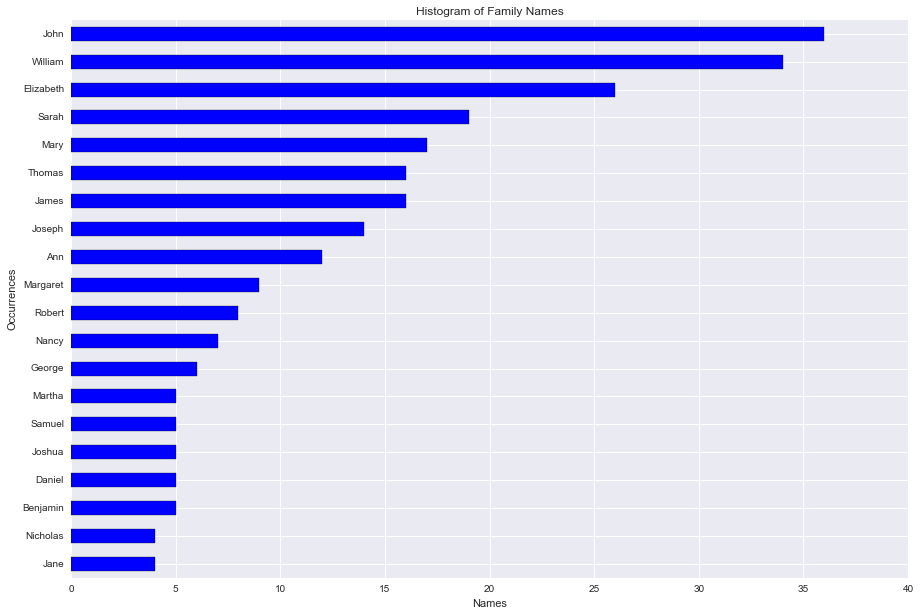

In [248]:
ax = family_names[:20].plot(kind = "barh", figsize = (15,10), title = "Histogram of Family Names")
ax.set_xlabel("Names")
ax.set_ylabel("Occurrences")

plt.gca().invert_yaxis()  # For descending order

When I initially did this, my data frame contained duplicates, and I saw the name "Keturah" appear with 6 instances.  I have never heard this name in the family before, so I decided to take a look at these records:

In [249]:
df[df['Given'].str.contains("Keturah") == True]

,PersonKey,Surname,Given,Gender,BirthDate,BirthPlace,DeathDate,DeathPlace,BurialPlace,Name,Family,FatherBirthDate,FatherBirthPlace,FatherDeathDate,FatherDeathPlace,FatherBurialPlace,FatherName,MotherBirthDate,MotherBirthPlace,MotherDeathDate,MotherDeathPlace,MotherBurialPlace,MotherName
397,[P363],Peddicord,Keturah,female,1706,"St Annes Parish, Anne Arundel, Maryland, Unite...",1759-12-00,"Baptism St Annes Parish, Anne Arundel, Marylan...",NaN,Keturah Peddicord,[F0056],1669,"Carroll's Manor, Frederick, Maryland, United S...",1732,"Baltimore, Maryland, USA",NaN,John Peddicord,1677,"Elk Ridge, Baltimore, Maryland, United States",1727,"Baltimore, Baltimore, Maryland, United States",NaN,Sarah Dorsey
525,[P415],Shipley,Keturah Roturah,female,1717-11-22,NaN,NaN,NaN,NaN,Keturah Roturah Shipley,[F0066],1726-09-20,"Parish, Anne Arundel, Maryland, USA",1789-06-12,"Shipley Advent, Anne Arundel, Maryland, United...",NaN,George Shipley,1694-01-01,"Ann Arundel Parish, Baltimore, Maryland, Unite...",1762-02-22,"Baltimore, Baltimore, Maryland, United States",NaN,Katherine Ogg


It looks like Keturah is the name of [Abraham's second wife](https://en.wikipedia.org/wiki/Keturah), which I suppose makes sense for ancestors from the colonial times to have that name.

In [250]:
df[df['Given'].str.contains("Craddock") == True]

,PersonKey,Surname,Given,Gender,BirthDate,BirthPlace,DeathDate,DeathPlace,BurialPlace,Name,Family,FatherBirthDate,FatherBirthPlace,FatherDeathDate,FatherDeathPlace,FatherBurialPlace,FatherName,MotherBirthDate,MotherBirthPlace,MotherDeathDate,MotherDeathPlace,MotherBurialPlace,MotherName
257,[P290],JOHNSON,John Craddock,male,1805-10-23,"Maryland, United States",1807-01-00,NaN,NaN,John Craddock JOHNSON,[F0043],1781-10-17,"Western Run, Baltimore, Maryland, United States",1829-09-24,"Baltimore, Maryland, United States","Doubs, Frederick County, Maryland, USA",Fayette Johnson,1784-10-09,"Worthington Valley, Baltimore, Maryland, Unite...",1816-07-12,"Baltimore, Maryland, USA",NaN,Elizabeth Cradock
290,[P284],Johnson,John Craddock,male,1805-10-23,"Maryland, United States",1807-01-00,NaN,NaN,John Craddock Johnson,[F0043],1781-10-17,"Western Run, Baltimore, Maryland, United States",1829-09-24,"Baltimore, Maryland, United States","Doubs, Frederick County, Maryland, USA",Fayette Johnson,1784-10-09,"Worthington Valley, Baltimore, Maryland, Unite...",1816-07-12,"Baltimore, Maryland, USA",NaN,Elizabeth Cradock
307,[P74],Johnson,Thomas Craddock,male,1810-02-25,"Saint Thomas, Baltimore, Maryland",1888-03-10,"Wilkinson, Mississippi, United States",NaN,Thomas Craddock Johnson,[F0043],1781-10-17,"Western Run, Baltimore, Maryland, United States",1829-09-24,"Baltimore, Maryland, United States","Doubs, Frederick County, Maryland, USA",Fayette Johnson,1784-10-09,"Worthington Valley, Baltimore, Maryland, Unite...",1816-07-12,"Baltimore, Maryland, USA",NaN,Elizabeth Cradock
308,[P79],Johnson,Thomas Craddock,male,1880-02-22,"Wilkinson County, Mississippi USA",1972-04-05,"Crosby, Amite County, Mississippi USA",NaN,Thomas Craddock Johnson,[F0015],1854-03-00,Mississippi,1945-08-19,"Mississippi, United States",NaN,Thomas Adolphus Johnson,1855-09-09,Mississippi,2 February 1896,"Wilkinson,Missisippi,USA",NaN,Ella Ruth Anderson


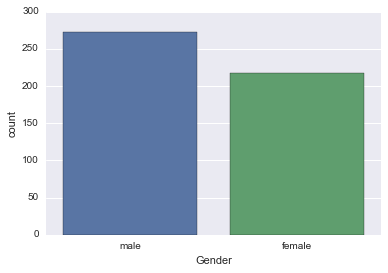

In [251]:
sns.countplot(x = "Gender", data = df)

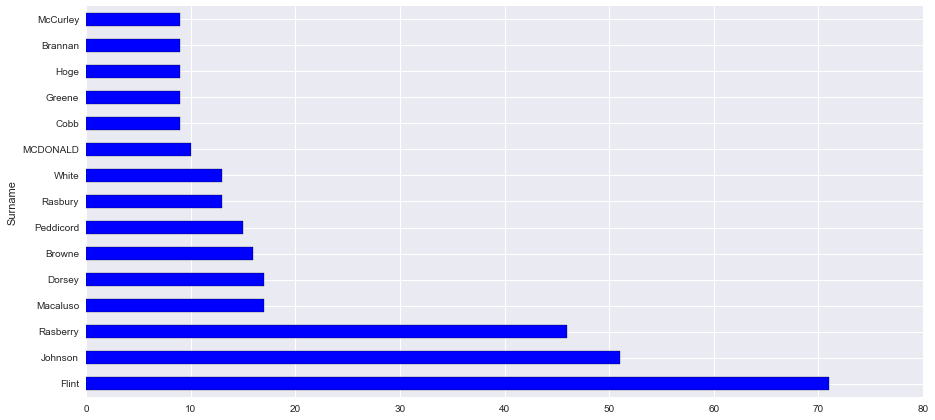

In [252]:
# Frequency of surnames
Surname = df[['Surname', 'PersonKey']].dropna()
Surname = Surname.groupby('Surname').count()
Surname = Surname.sort_values(by = 'PersonKey', ascending = 0)
# sns.barplot(x = "PersonKey", y = "Surname", data = Surname)
Surname[:15].plot(kind = 'barh', figsize = (15, 7), legend = False)
# sns.countplot(y='Surname', data=Surname[:15], palette="Greens_d");

In [253]:
# Creating a dictionary of states and their codes to extract places into states
states = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missisippi': 'MS',  # to account for spelling errors
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

# Reverses the above dictionary to extract state abbreviations using the same function
states_reverse = dict(zip(states.values(),states.keys()))

In [254]:
# Extracting the state from various addresses
def state_extract(dict1, dict2, column):
    """
    Extracts the state from the place columns if any part of the record exists 
    within the state dictionary or reverse state dictionary
    
    dict1 is the regular state dictionary, dict2 is the reverse state dictionary for state abbreviations
    """
    return pd.Series([[state.strip() for state in cell.split(',')
               if state.strip() in dict1
                   or state.strip().upper() in dict2]  # dict2 for state abbreviations
              for cell in column.fillna("null")])
    
    
# Running functions to extract the states into series
BirthState = state_extract(states, states_reverse, df['BirthPlace'])
DeathState = state_extract(states, states_reverse, df['DeathPlace'])

FatherBirthState = state_extract(states, states_reverse, df['FatherBirthPlace'])
FatherDeathState = state_extract(states, states_reverse, df['FatherDeathPlace'])

MotherBirthState = state_extract(states, states_reverse, df['MotherBirthPlace'])
MotherDeathState = state_extract(states, states_reverse, df['MotherDeathPlace'])


# Assigns series generated from the function to columns and removes brackets surrounding values
df['BirthState'] = BirthState.apply(lambda s: s[-1] if s else np.NaN)
df['DeathState'] = DeathState.apply(lambda s: s[-1] if s else np.NaN)

df['FatherBirthState'] = FatherBirthState.apply(lambda s: s[-1] if s else np.NaN)
df['FatherDeathState'] = FatherDeathState.apply(lambda s: s[-1] if s else np.NaN)

df['MotherBirthState'] = MotherBirthState.apply(lambda s: s[-1] if s else np.NaN)
df['MotherDeathState'] = MotherDeathState.apply(lambda s: s[-1] if s else np.NaN)


# Converts from abbreviated state to full state name in title case
df['BirthState'] = df['BirthState'].str.upper().replace(states_reverse).str.title()
df['DeathState'] = df['DeathState'].str.upper().replace(states_reverse).str.title()

df['FatherBirthState'] = df['FatherBirthState'].str.upper().replace(states_reverse).str.title()
df['FatherDeathState'] = df['FatherDeathState'].str.upper().replace(states_reverse).str.title()

df['MotherBirthState'] = df['MotherBirthState'].str.upper().replace(states_reverse).str.title()
df['MotherDeathState'] = df['MotherDeathState'].str.upper().replace(states_reverse).str.title()

df[['BirthPlace', 'BirthState', 'DeathPlace', 'DeathState', 'FatherBirthState', 'MotherBirthState']].ix[:3]

,BirthPlace,BirthState,DeathPlace,DeathState,FatherBirthState,MotherBirthState
0,Mississippi,Mississippi,NaN,NaN,Mississippi,Mississippi
1,"South Carolina, USA",South Carolina,"Winston, Mississippi, United States",Mississippi,NaN,NaN
2,",, Sc",South Carolina,NaN,NaN,NaN,NaN
3,"Davie, North Carolina, United States",North Carolina,"St Stephen, Greene, Alabama, United States",Alabama,NaN,NaN


In [255]:
# Adjust for "Missisippi" spelling error
df.replace("Missisippi", "Mississippi", inplace = True)

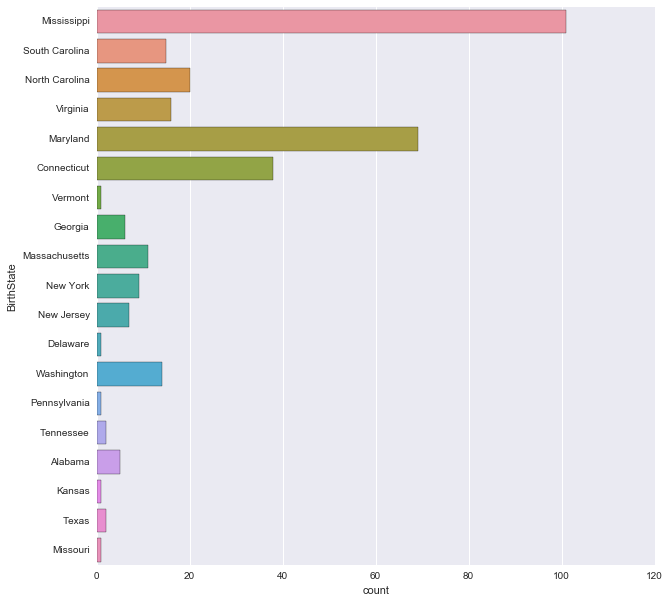

In [256]:
fig, ax = plt.subplots()

fig.set_size_inches(10, 10)
sns.countplot(y = 'BirthState', data = df)

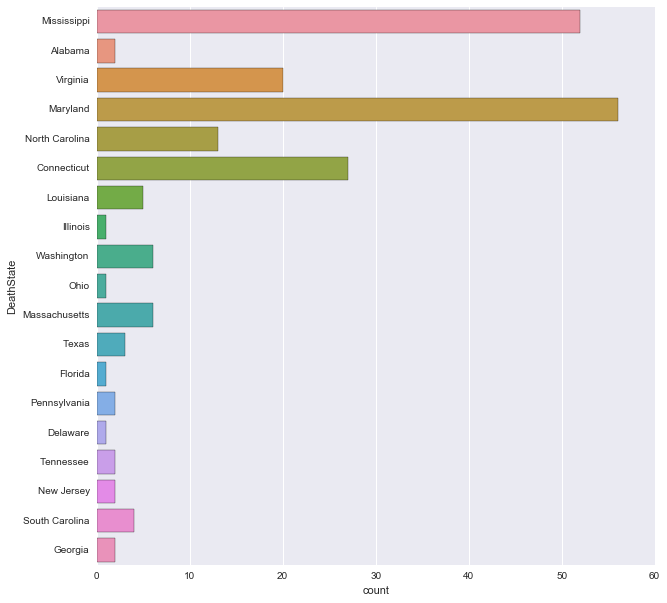

In [257]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 10)
sns.countplot(y = 'DeathState', data = df)

In [258]:
# Creates binary columns to show if the individual died where they were born and if they're currently alive
df['BirthState'].fillna(np.NaN)
df['DiedWhereBorn'] = np.where(df['BirthState'] == df['DeathState'], 1, np.where(df['DeathState'].isnull(), np.NaN, 0))  # Also add NaN
df['IsAlive'] = np.where(df['DeathPlace'].notnull() == True, 1, np.where(df['BirthState'].isnull(), np.NaN, 0))

In [259]:
# Creates binary columns for if the individual was born in their mother or father's states.  Will be used to calculate mobility
df['BornInFatherState'] = np.where(df['BirthState'] == df['FatherBirthState'], 1, np.where(df['FatherBirthState'].isnull(), np.NaN, 0))
df['BornInMotherState'] = np.where(df['BirthState'] == df['MotherBirthState'], 1, np.where(df['MotherBirthState'].isnull(), np.NaN, 0))

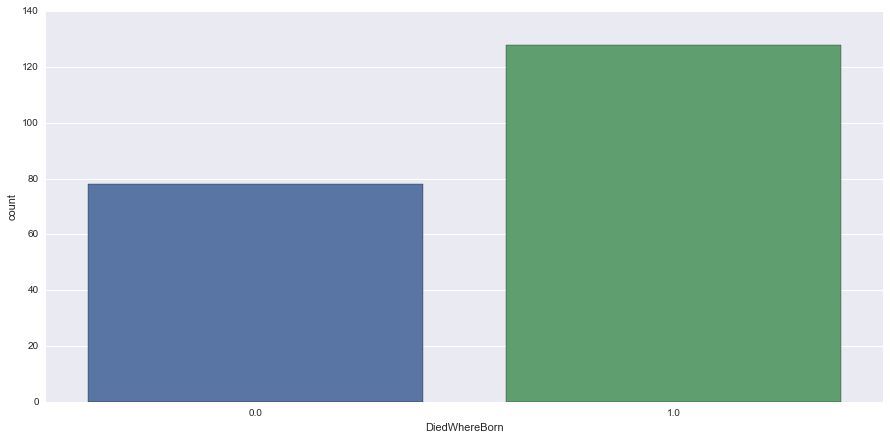

In [260]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

sns.countplot(x = 'DiedWhereBorn', data = df)

I checked unique values after extracting the United States out of all birth place columns and filtered them to not include it to check if this dictionary contained everything.  This list ended up being more comprehensive, but I left it for future use for other GEDCOM files

In [261]:
countries = {
    # Europe
    'England': 'EN',
    'Scotland': 'SC',
    'Wales': 'WL',
    'Ireland': 'IR',
    'Rebpulic of Ireland': 'IR',
    'Great Britain': 'GB',
    'Britain': 'GB',
    'United Kingdom': 'UK',
    'Italy': 'IT',
    'ITA': 'IT',
    'Germany': 'DE',
    'France': 'FR',
    'Denmark': 'DR',
    'Sweden': 'SW',
    'Norway': 'NR',
    'Canada': 'CN',
    'Netherlands': 'ND',
    'Spain': 'SP',
    'Belgium': 'BG',
    'Poland': 'PL',
    'Austria': 'AR',
    'Portugal': 'PR',
    'Russia': 'RU',
    'Hungary': 'HR',
    'Slovakia': 'SL',
    'Greece': 'GR',
    
    # North America
    'United States': 'US',
    'USA': 'US',
    'US': 'US',
    'Mexico': 'MX'
}

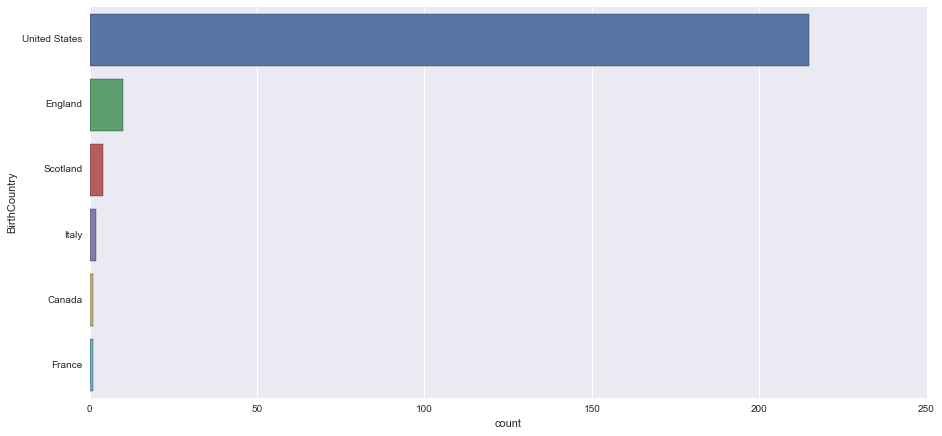

In [262]:
# Extracting the country from birth addresses
BirthCountry = pd.Series([[state.strip() for state in cell.split(',') 
                  if state.strip() in countries] 
                 for cell in df.BirthPlace.fillna("null")])

df['BirthCountry'] = BirthCountry.apply(lambda s: s[-1] if s else np.NaN)
df['BirthCountry'] = np.where(df['BirthCountry'] == 'USA', 'United States', df['BirthCountry'])

fig, ax = plt.subplots()

fig.set_size_inches(15, 7)
sns.countplot(y = 'BirthCountry', data = df)

In [281]:
# Binning the birth years into decades

Years_int = np.arange(1500, 2020)  # To extract the birth and death years
Years = [str(s) for s in Years_int]  # Changes the data type to a string to scan the column


decades = np.arange(1600, 2020, 10)
decades_labels = [(str(s)+"'s") for s in decades]  # Changes the data type to a string to scan the column
del decades_labels[-1]  # Removes the last record to use as the labels in the pd.cut



# Extracting the birth year from the date
BirthYear = pd.Series([[date.strip() for date in cell.split(' ')
                  if date.strip() in Years]
                 for cell in df['BirthDate'].str.replace('-', ' ').fillna("null")])

# Applying the bins
df['BirthYear'] = BirthYear.apply(lambda s: s[-1] if s else np.NaN)
df['BirthYear'] = pd.to_numeric(df['BirthYear'])
df['BirthDecade'] = pd.cut(df['BirthYear'], decades, labels = decades_labels)

# df[['BirthDate', 'BirthYear', 'BirthDecade']]

In [295]:
# df['BirthYear'] = BirthYear
# BirthYear
# df['BirthYear'].tail()
# df[['BirthDate', 'BirthYear', 'BirthDecade']].tail()

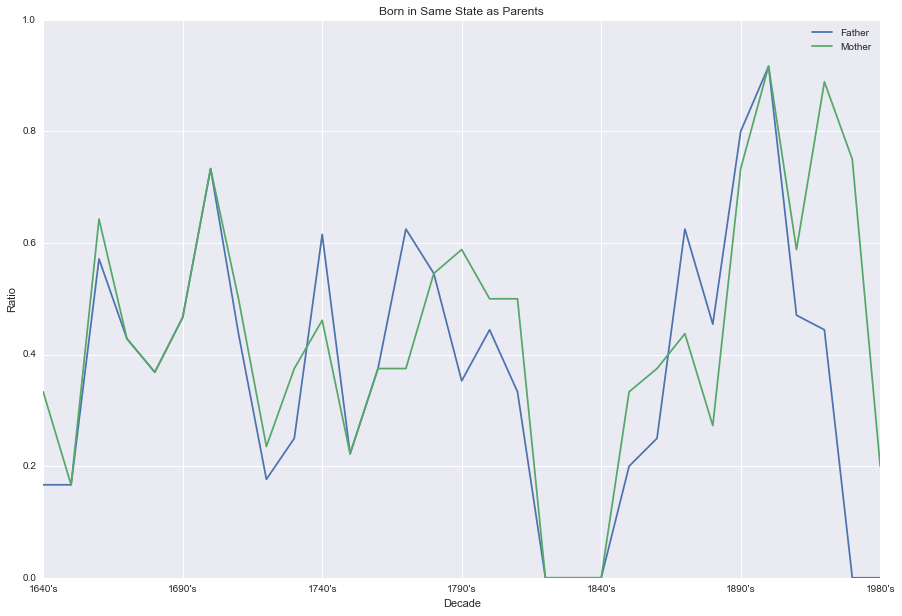

In [264]:
# Calculating ratios to view mobility of generations
born_in_father_state_ratio = df['BornInFatherState'].groupby(df['BirthDecade']).sum() / df.groupby(['BirthDecade']).size()
born_in_mother_state_ratio = df['BornInMotherState'].groupby(df['BirthDecade']).sum() / df.groupby(['BirthDecade']).size()

BirthRatio = pd.concat([born_in_father_state_ratio, born_in_mother_state_ratio], axis=1)
BirthRatio.columns = ['Father', 'Mother']

ax = BirthRatio.dropna().plot(title = "Born in Same State as Parents", figsize = (15,10))
ax.set_ylabel("Ratio")
ax.set_xlabel("Decade")

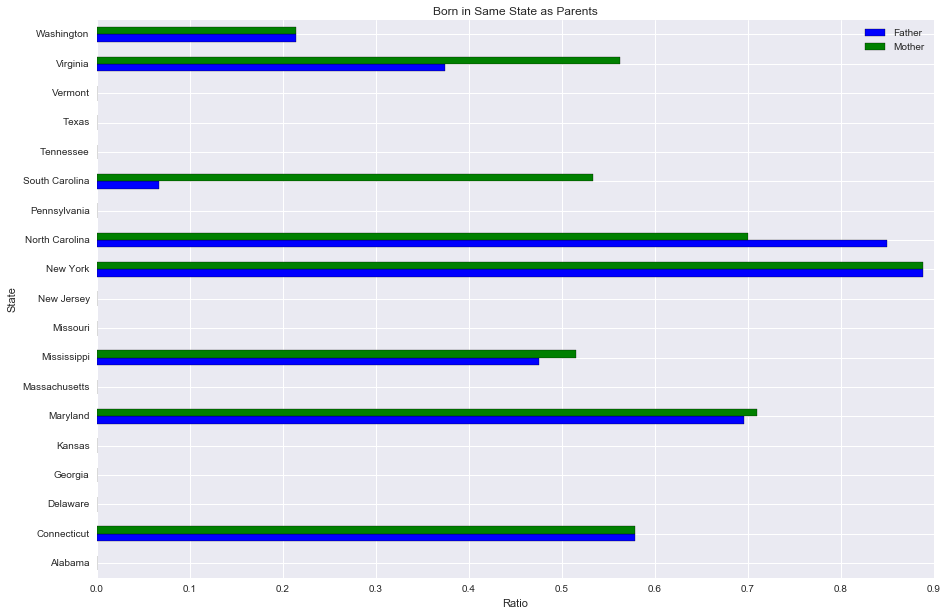

In [265]:
FatherStateBirthRatio = df['BornInFatherState'].groupby(df['BirthState']).sum() / df.groupby(['BirthState']).size()
MotherStateBirthRatio = df['BornInMotherState'].groupby(df['BirthState']).sum() / df.groupby(['BirthState']).size()

BirthRatioByState = pd.concat([FatherStateBirthRatio, MotherStateBirthRatio], axis=1)
BirthRatioByState.columns = ['Father', 'Mother']
ax = BirthRatioByState.plot(kind = "barh", figsize = (15, 10), title = "Born in Same State as Parents")
ax.set_xlabel("Ratio")
ax.set_ylabel("State")

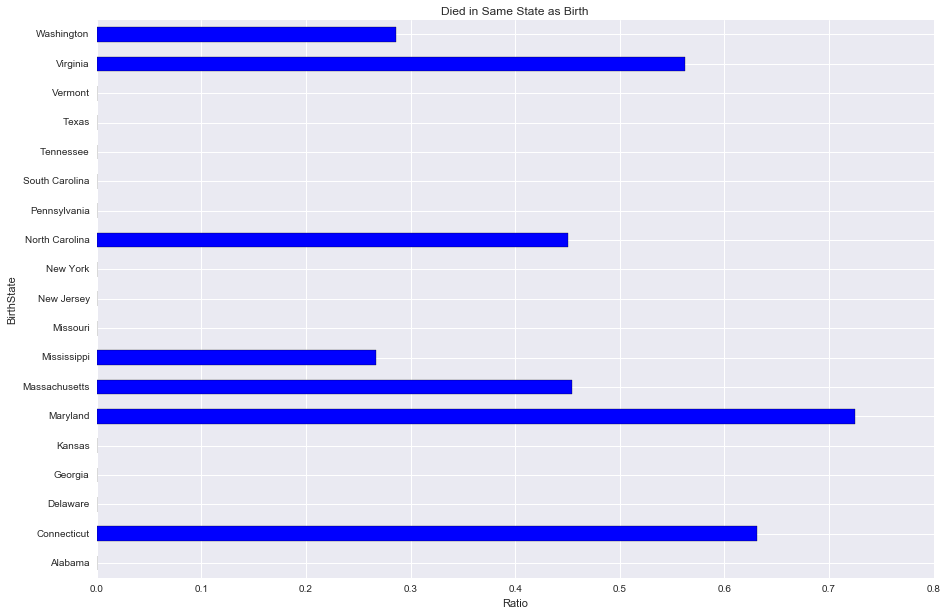

In [266]:
DiedWhereBornRatio = df['DiedWhereBorn'].groupby(df['BirthState']).sum() / df.groupby(['BirthState']).size()
DiedWhereBornRatio.plot(kind = "barh", figsize = (15,10), title = "Died in Same State as Birth").set_xlabel("Ratio")

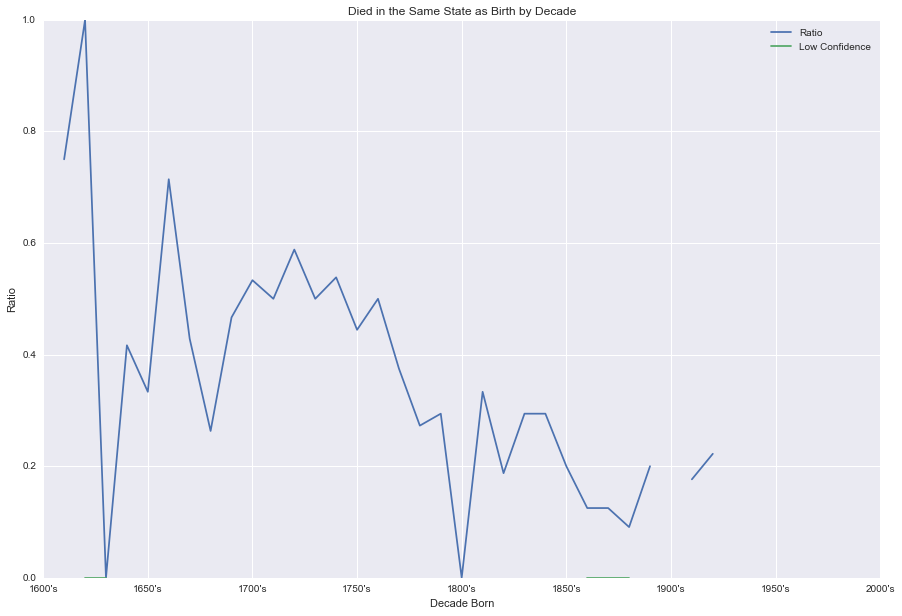

In [267]:
# To examine the trend of mobility by decade by ratios of population that died in the same state they were born in
died_where_born_ratio = df['DiedWhereBorn'].groupby(df['BirthDecade']).sum() / df.groupby(['BirthDecade']).size()
died_where_born_population = df['DiedWhereBorn'].groupby(df['BirthDecade']).count()  # To be used in the confidence
died_where_born = pd.concat([died_where_born_ratio, died_where_born_population], axis=1)
died_where_born.columns = ['Ratio', 'Confidence']

# Assigns a normalized "confidence" score based off of the population
died_where_born['Confidence'] -= died_where_born['Confidence'].min()
died_where_born['Confidence'] /= died_where_born['Confidence'].max()
# A "Low Confidence" bucket for the plot
died_where_born['Low Confidence'] = np.where(died_where_born['Confidence'] < 0.25, 0, np.NaN)
died_where_born['Low Confidence'] = np.where(died_where_born['Ratio'].isnull(), np.NaN, died_where_born['Low Confidence'])
died_where_born.drop(['Confidence'], axis = 1, inplace = True)


# sns.tsplot(data=died_where_born_ratio, xlab)
ax = died_where_born.plot(title = "Died in the Same State as Birth by Decade",
                     figsize = (15,10))
ax.set_ylabel("Ratio")
ax.set_xlabel("Decade Born")

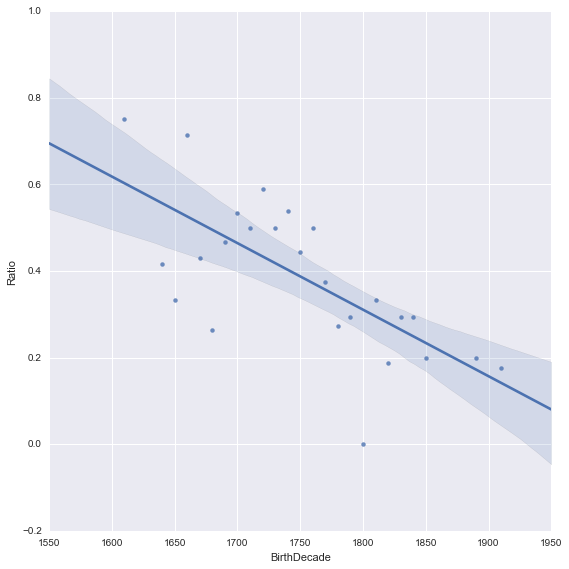

In [268]:
# https://github.com/matplotlib/basemap/blob/master/examples/fillstates.py
# http://stackoverflow.com/questions/7586384/color-states-with-pythons-matplotlib-basemap
# http://wrobstory.github.io/2013/04/python-maps-choropleth.html

test = died_where_born.reset_index()
test['Low Confidence'].replace(0, 1, inplace = True)
test['Low Confidence'].fillna(0, inplace = True)
test = test.dropna()
# sns.lmplot(x="BirthDecade", y="Ratio", data=test)
# sns.tsplot(data=test, err_style="ci_bars")
# test[test['Low Confidence'] == 0]['Low Confidence'] = 1
# test[test[['Low Confidence']]] = 1
# sns.regplot(x="BirthDecade", y="Ratio", data=test)
test['BirthDecade'] = test['BirthDecade'].str.strip("'s")
test['BirthDecade'] = test['BirthDecade'].astype(int)
sns.lmplot(x="BirthDecade", y="Ratio", data=test[test['Low Confidence'] == 0], size = 8)
# sns.jointplot(x="BirthDecade", y="Ratio", data=test[test['Low Confidence'] == 0], kind="reg");

In [269]:
# https://plot.ly/python/ipython-notebook-tutorial/
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
py.sign_in('macal030', 'shk3itdiwv')


scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['BirthState'].dropna()
    
data = [dict(
    type='choropleth',
    colorscale = scl,
    autocolorscale = False,
    locations = df['BirthState'].dropna(),
    z = df['DiedWhereBorn'].astype(float)*100,
    locationmode = 'USA-states',
    text = df['text'],
    hoverinfo = 'location+z',
    marker = dict(
        line = dict (
            color = 'rgb(255,255,255)',
            width = 2
        )
    ),
    colorbar = dict(
        title = "Votes"
    )
)]

layout = dict(
    title = '2016 Electoral College Votes<br>(Hover for breakdown)',
    geo = dict(
        scope='usa',
        projection=dict( type='albers usa' ),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)'
    )
)
    
fig = dict(data=data, layout=layout)

py.iplot(fig, validate=False, filename='d3-electoral-map')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~macal030/0 or inside your plot.ly account where it is named 'd3-electoral-map'


In [270]:
import vincent
vincent.core.initialize_notebook()

world_topo = r'world-countries.topo.json'
geo_data = [{'name': 'countries',
             'url': world_topo,
             'feature': 'world-countries'}]

vis = vincent.Map(geo_data=geo_data, scale=200)
geo_data.show()

AttributeError: 'list' object has no attribute 'show'

In [ ]:
from mpl_toolkits.basemap import Basemap


In [ ]:
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
# import json


# find the unemployment rate for the selected county, and convert it to color
# def get_color(properties):
#     key = str(int(properties['STATE'])) + properties['COUNTY']
#     if key in unemployment:
#         return cmap.to_color(unemployment.get(key), .15, 'lin')
#     else:
#         return [0, 0, 0, 0]


# with open('data/unemployment.json') as fin:
#     unemployment = json.load(fin)

# cmap = ColorMap('Blues', alpha=255, levels=10)
# geoplotlib.geojson('data/gz_2010_us_050_00_20m.json', fill=True, color=get_color, f_tooltip=lambda properties: properties['NAME'])
# geoplotlib.geojson('data/gz_2010_us_050_00_20m.json', fill=False, color=[255, 255, 255, 64])
# geoplotlib.set_bbox(BoundingBox.USA)
# geoplotlib.show()

In [ ]:
import missingno as msno

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

In [ ]:
import missingno as msno

msno.matrix(df)